In [1]:
##This is to analyze the sequences I get back from the libraries and eventually plot in PyMol figures. I am going to import the
##Nucleotide alignment after exporting a FASTA file from Geneious. This is made by aligning the chromatograms from Sanger reads.

#Importing the necessary libraries
import sys
import os
from os import listdir
from os.path import isfile, join

import re

import pandas as pd

import Bio
from Bio import AlignIO
from Bio import SeqIO
from Bio import SeqUtils

from pylab import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import kendalltau
from scipy.stats import chisquare
from scipy.stats import spearmanr

#Setting matplotlib to be inline, and setting the fonttype for the pdf export to be consistent in Illustrator.
%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Set the root directory
root_dir = './Data';

In [2]:
###Classes defined###
class FASTAClass:
    def __init__(self, id, seq):        
        self.id = id        
        self.seq = seq

###Functions used here###
def sequenceCleaner(mutants):
    # Create our hash table to add the sequences
    seqHash={}
    seqUnique = []

    # Using the Biopython fasta parse we can read our fasta input
    for seq_record in mutants[1:]:
        # Take the current sequence
        sequence = str(seq_record.seq).upper()
        # If the sequence passed in the test "is it clean?" and it isn't in the
        # hash table, the sequence and its id are going to be in the hash
        if sequence not in seqHash:
            seqHash[sequence] = seq_record.id
        # If it is already in the hash table, we're just gonna concatenate the ID
        # of the current sequence to another one that is already in the hash table
        else:
            seqHash[sequence] += "_" + seq_record.id.split("_")[-3].split("-")[-1]
    
    # Making the final FASTAClass for the unique sequences
    seqUnique.append(FASTAClass(mutants[0].id, mutants[0].seq))
    for sequence in seqHash:
        seqUnique.append(FASTAClass(seqHash[sequence], sequence))
            
    return seqUnique

In [3]:
#Set the data directory
data_dir = '';

#Pick a test data file
data_file = root_dir+data_dir
#print(root_dir+data_dir)

#Printing file list
fileList = [f for f in listdir(root_dir+data_dir) if (f.endswith(".fasta") or f.endswith(".csv"))]
print("Sequence files:")
print("\n".join(fileList))

Sequence files:
20181215_STE6Sc_Sergey-allDBv2_Fungi-v2p1_hmmalign_hhfilter-focus-mod Yl-Sc STE6.fasta
E-021_TMH4-6_v3-org_nucl-align.fasta
E-021_TMH4-6_v3-org_nucl-align_191106.fasta
E-021_TMH4-6_v3-org_nucl-align_191106_unique.fasta
E-021_TMH4-6_v3-org_nucl-align_unique.fasta
E-021_TMH4-6_v3-sort04_nucl-align.fasta
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all.fasta
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier-no493_191128.fasta
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier-no493_191128_Autocrine_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier-no493_191128_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier-no493_191128_unique-translate.fasta
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04

In [4]:
print(not(os.path.isdir(root_dir)))

False


In [5]:
##Input an alignment for the analysis, and run my pre-cleaning on the Alignment.

alignFile = data_file+"/E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_unique_no-outliers 191031.fasta"
nuclAlignment = AlignIO.read(open(alignFile), "fasta")
print("Alignment length %i" % nuclAlignment.get_alignment_length())
print("Alignment size %i" % len(nuclAlignment))
#for record in nuclAlignment :
#    print(record.seq[:120])

#print(nuclAlignment[1].seq)
#print(nuclAlignment[1].seq.ungap("-").translate())

reducedNuclAlignment = []
for record in nuclAlignment:
    if (record.seq.count("-") == 0):
        reducedNuclAlignment.append(record)

print("Reduced alignment size %i" % len(reducedNuclAlignment))
#for record in reducedNuclAlignment:
#    print(record.seq.translate())

reducedAaAlignment = []
for record in reducedNuclAlignment:
    reducedAaAlignment.append(FASTAClass(record.id, record.seq.translate()))

cleanedAaAlignment = sequenceCleaner(reducedAaAlignment)
cleanedNuclAlignment = sequenceCleaner(reducedNuclAlignment)
print("Cleaned Aa alignment size %i" % len(cleanedAaAlignment))
print("Cleaned Nucl alignment size %i" % len(cleanedNuclAlignment))
print(cleanedAaAlignment[0].id, cleanedAaAlignment[0].seq)

#print(reducedAaAlignment[-1].id.split("_")[-3])
#print(cleanedAaAlignment[-2].id)

outputUniqueNucl = alignFile[:-6]+"_unique.fasta"
outputHandle = open(outputUniqueNucl,"w")
for sequence in cleanedNuclAlignment:
    outputHandle.write(">"+str(sequence.id)+"\n"+str(sequence.seq)+"\n")
outputHandle.close()
print("Unique sequences are printed in:\t", outputUniqueNucl)

outputUniqueAa = alignFile[:-6]+"_unique-translate.fasta"
outputHandle = open(outputUniqueAa,"w")
for sequence in cleanedAaAlignment:
    outputHandle.write(">"+str(sequence.id)+"\n"+str(sequence.seq)+"\n")
outputHandle.close()
print("Unique sequences are printed in:\t", outputUniqueAa)

Alignment length 483
Alignment size 60
Reduced alignment size 60
Cleaned Aa alignment size 60
Cleaned Nucl alignment size 60
YALI0E05973[TMH4-6]_ROI YHSWSLTLVIMAGLPIIVLVAMGVAPRLQRHFRDYKGVITDASVMIDWSMSGLQHVKLSNGEKKQMSILQYQMHLATICYMKFTTWSAAQQAFMQVLALIMFVQGFWFGAKQVQIGNLTAGAVMTCFFSAMAVTSHIASITGQMMSIMKAMVSAGLVNQLI
Unique sequences are printed in:	 ./Data/E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_unique_no-outliers 191031_unique.fasta
Unique sequences are printed in:	 ./Data/E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_unique_no-outliers 191031_unique-translate.fasta


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text yticklabel objects>)

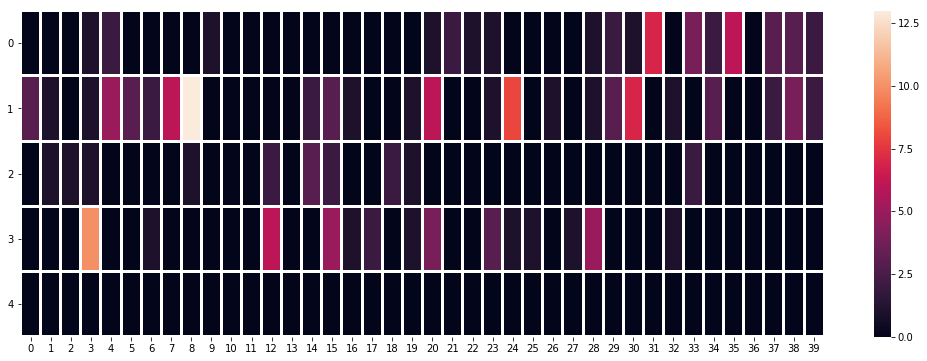

In [6]:
##I am going to write code that gives the number of variation in each column.
#mutantCounts = [[0 for col in range(len(cleanedTestAlignment[0].seq))] for row in range(len(cleanedTestAlignment)-1)]
mutantCounts = [0 for col in range(len(cleanedAaAlignment[0].seq))]

#print(len(cleanedTestAlignment[1].seq))

seqCount = 0
for record in cleanedAaAlignment[1:]:
    residueCount = 0
    for residue in record.seq:
        #print(residue, residueCount, seqCount)
        if residue != cleanedAaAlignment[0].seq[residueCount]:
            mutantCounts[residueCount] += 1
        residueCount += 1
    seqCount +=1

#print(seqCount, residueCount)
#print(mutantCounts)

heatMapMutations = [[0 for i in range(40)] for j in range(len(cleanedAaAlignment[0].seq)//40+1)]

for iterCount in range(len(cleanedAaAlignment[0].seq)):
    #print(iterCount)
    heatMapMutations[(iterCount)//40][(iterCount)%40] = mutantCounts[iterCount]
#print(heatMapMutations)

fig1 = figure(figsize=(18,6))
ax = sns.heatmap(heatMapMutations, linewidths=2)
plt.yticks(rotation=0)
#savefig(root_dir+'/heatMap_TMH4-6_all_uniques.pdf', dpi=300, transparent=True)

In [7]:
##I am going to output a file that can be ingested into PyMol directly by the <data2b_res.py> script. I need to remember that the order is "ChainID, 3-letter-aa, resi, b-factor"
outputFile = alignFile.split(".")[1]+"_mutantCounts.csv"
print(outputFile)

startTMH4to6 = 199
startTMH10to12 = 851
chainID = "A"
mutantCountsPyMolList = []
resiCount = 0
for resiCount in range(len(cleanedAaAlignment[0].seq)):
    mutantCountsPyMolList.append([chainID, (startTMH4to6+resiCount), SeqUtils.seq3(cleanedAaAlignment[0].seq[resiCount]).upper(), mutantCounts[resiCount]])
#print(mutantCountsPyMolList)
#print(len(cleanedAaAlignment[0].seq))
mutantCountsPyMol = pd.DataFrame.from_records(mutantCountsPyMolList)
#print(mutantCountsPyMol)

#mutantCountsPyMol.to_csv('.'+outputFile, sep='\t', encoding='utf-8', index=False, header=False)

/Data/E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_unique_no-outliers 191031_mutantCounts.csv


In [10]:
SeqUtils.seq3("ARG").upper()

print("Max mutants/pos: ", max(mutantCounts[:]), "\nSum of unique mutations: ", sum(mutantCounts))
#len(mutantCounts)
#print(range(161))

Ticks = list(range(max(mutantCounts[:])+1))
print(Ticks)

#read_file = data_file+"/Fungiv2p1_hmmalign-hhfilter_graphs.csv"
read_file = data_file+"/Fungiv2p1_hmmalign-hhfilter-focus-mod_cleaned-v2_200114.csv"
orthologAlign = pd.read_csv(read_file)
print(orthologAlign['Identity'].values[startTMH4to6-1:startTMH4to6-1+len(mutantCounts)])
print(orthologAlign[startTMH4to6-1:startTMH4to6+2])

Max mutants/pos:  13 
Sum of unique mutations:  178
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.27 0.14 0.72 0.68 0.18 0.83 0.71 0.8  0.67 0.29 0.53 0.36 0.23 0.22
 0.9  0.24 0.15 0.12 0.19 0.22 0.16 0.12 0.19 0.14 0.23 0.16 0.12 0.17
 0.11 0.34 0.13 0.21 0.11 0.12 0.42 0.21 0.1  0.12 0.34 0.2  0.09 0.71
 0.31 0.33 0.14 0.23 0.14 0.18 0.38 0.2  0.15 0.32 0.68 0.18 0.36 0.85
 0.78 0.22 0.43 0.69 0.4  0.24 0.11 0.09 0.84 0.12 0.09 0.14 0.31 0.08
 0.09 0.13 0.22 0.11 0.12 0.25 0.2  0.1  0.11 0.33 0.11 0.21 0.24 0.3
 0.12 0.12 0.2  0.29 0.16 0.33 0.14 0.46 0.13 0.13 0.2  0.46 0.16 0.18
 0.18 0.17 0.43 0.92 0.73 0.49 0.77 0.91 0.68 0.47 0.87 0.2  0.12 0.7
 0.57 0.16 0.1  0.73 0.14 0.18 0.19 0.28 0.67 0.19 0.69 0.25 0.45 0.32
 0.94 0.38 0.56 0.41 0.68 0.16 0.51 0.15 0.29 0.17 0.28 0.25 0.12 0.16
 0.19 0.54 0.36 0.18 0.23 0.28 0.48 0.15 0.73 0.79 0.29 0.15 0.69 0.24
 0.17 0.13 0.71 0.1  0.11 0.26 0.16]
     Position  Coverage  Identity  Mean Hydrophobicity  Mean PI  Sequence Logo
198   

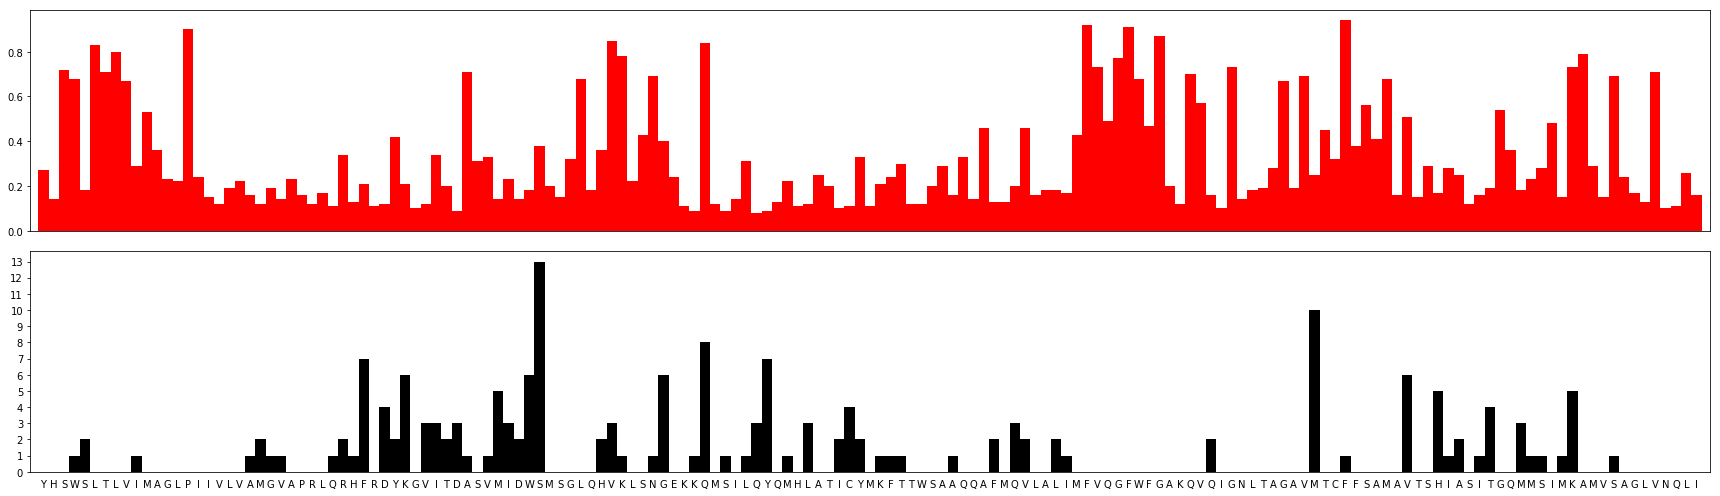

In [12]:
fig2 = figure(figsize=(24,7))
ax1 = subplot(211)
ax1 = plt.bar(range(161), (orthologAlign['Identity'].values[startTMH4to6-1:startTMH4to6-1+len(mutantCounts)]), width=1, align='center', color="red")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) #No labels are shown
plt.margins(x=0.005)
#print(plt.ylim())

ax2 = subplot(212)
ax2 = plt.bar(range(161), (mutantCounts), width=1, align='center', color="black", tick_label=cleanedAaAlignment[0].seq)
plt.yticks(Ticks)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)         # ticks along the top edge are off
plt.margins(x=0.005)
plt.tight_layout()



#savefig(root_dir+'/barMap_TMH4-6_all_uniques_200114.pdf', dpi=300, transparent=True)

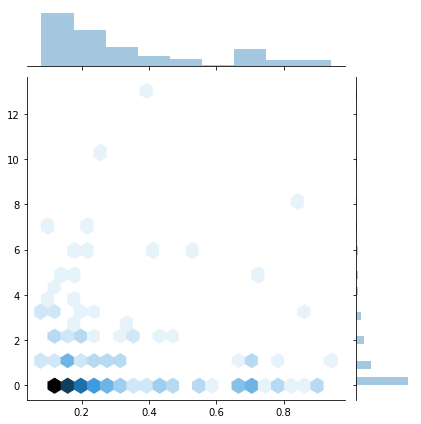

In [10]:
sns.jointplot(x=(orthologAlign['Identity'].values[startTMH4to6-1:startTMH4to6-1+len(mutantCounts)]), y=(mutantCounts), kind="hex")

[2 1 2 0 1 3 0 2 0 0] 
Lambda =  1.1055900621118013 	Size =  161
[96, 27, 14, 9, 3, 3, 4, 2, 1, 0, 1, 0, 0, 1]
[53.29349628848248, 58.9207598717384, 32.5711032831349, 12.003429367283669, 3.3177180549324423, 0.7336072220844411, 0.13517814237166711, 0.021350230117264186, 0.0029505752801809184, 0.0003624585230311973, 4.0073054099101264e-05, 4.027670033675909e-06, 3.7107933022479917e-07, 3.15585861347417e-08, 2.4922042289192502e-09]

The chi-square test gives us:  31712748.736222938 	at p-value:  0.0


(-1, 16)

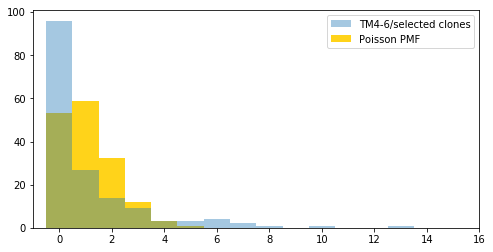

In [11]:
##I am going to Poisson sample the number of mutations that are going to be drawn for this range.
##I need to add an extra bin since the this list is a right limit of bins and it inappropriately counts the highest mutCount values in the bin.
#bins = list(range(max(mutantCounts)+2))
bins = np.arange(max(mutantCounts)+2)

mutCountsPoisson = np.random.poisson(sum(mutantCounts)/len(mutantCounts), len(mutantCounts))
mutPoissonPmf = len(mutantCounts)*poisson.pmf(bins, sum(mutantCounts)/len(mutantCounts))
#print(mutPoissonPmf)

print(mutCountsPoisson[:10], "\nLambda = ", sum(mutantCounts)/len(mutantCounts), "\tSize = ", len(mutCountsPoisson))
#sns.palplot(sns.color_palette()[1])

histMutantCounts, bin_edges = np.histogram(mutantCounts, bins)
print(histMutantCounts.tolist()[:])
print(mutPoissonPmf.tolist()[:])
print()
chiSquare, chiSqpval = chisquare(histMutantCounts, mutPoissonPmf[:len(histMutantCounts)])
print("The chi-square test gives us: ", chiSquare, "\tat p-value: ", chiSqpval)


fig3 = figure(figsize=(8,4))
ax2 = plt.bar(bins, mutPoissonPmf, label="Poisson PMF", color="#FFD31A", align="center", width=1)
#ax2 = plt.bar(bins, mutPoissonPmf, label="Poisson PMF", color=sns.color_palette()[1], align="edge", width=1)
#ax2 = sns.distplot(mutCountsPoisson, bins, kde=False, label="Poisson distribution")
#ax2 = sns.barplot(bins, histMutantCounts.tolist()[:], label="TM4-6/selected clones")
ax2 = sns.distplot(mutantCounts, bins - 0.5, kde=False, label="TM4-6/selected clones")
ax2.legend()
xlim((-1,bins[-1]+2))

#savefig(root_dir+'/mutCountPosHist_TMH4-6_all_uniques_191124.pdf', dpi=300, transparent=True)

[1 0 0 1 0 2 1 2 0 0] 
Lambda =  1.1055900621118013 	Size =  161
[96, 27, 14, 9, 3, 3, 4, 2, 1, 0, 1, 0, 0, 1]
[53.29349628848248, 58.9207598717384, 32.5711032831349, 12.003429367283669, 3.3177180549324423, 0.7336072220844411, 0.13517814237166711, 0.021350230117264186, 0.0029505752801809184, 0.0003624585230311973, 4.0073054099101264e-05, 4.027670033675909e-06, 3.7107933022479917e-07, 3.15585861347417e-08, 2.4922042289192502e-09]

The chi-square test gives us:  31712748.736222938 	at p-value:  0.0


(-1, 16)

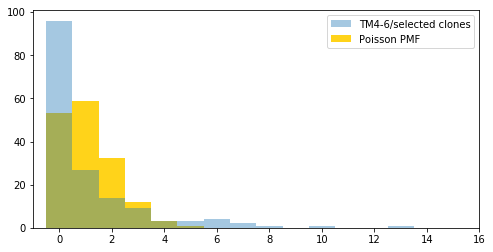

In [12]:
##I am going to Poisson sample the number of mutations that are going to be drawn for this range.
##I need to add an extra bin since the this list is a right limit of bins and it inappropriately counts the highest mutCount values in the bin.
##I have corrected the p-value estimation by Chi-square to incorporate the mean estimation done for the theoretical Poisson mass distribution.
#bins = list(range(max(mutantCounts)+2))
bins = np.arange(max(mutantCounts)+2)

mutCountsPoisson = np.random.poisson(sum(mutantCounts)/len(mutantCounts), len(mutantCounts))
mutPoissonPmf = len(mutantCounts)*poisson.pmf(bins, sum(mutantCounts)/len(mutantCounts))
#print(mutPoissonPmf)

print(mutCountsPoisson[:10], "\nLambda = ", sum(mutantCounts)/len(mutantCounts), "\tSize = ", len(mutCountsPoisson))
#sns.palplot(sns.color_palette()[1])

histMutantCounts, bin_edges = np.histogram(mutantCounts, bins)
print(histMutantCounts.tolist()[:])
print(mutPoissonPmf.tolist()[:])
print()
chiSquare, chiSqpval = chisquare(histMutantCounts, mutPoissonPmf[:len(histMutantCounts)], ddof=1)
print("The chi-square test gives us: ", chiSquare, "\tat p-value: ", chiSqpval)


fig3 = figure(figsize=(8,4))
ax2 = plt.bar(bins, mutPoissonPmf, label="Poisson PMF", color="#FFD31A", align="center", width=1)
#ax2 = plt.bar(bins, mutPoissonPmf, label="Poisson PMF", color=sns.color_palette()[1], align="edge", width=1)
#ax2 = sns.distplot(mutCountsPoisson, bins, kde=False, label="Poisson distribution")
#ax2 = sns.barplot(bins, histMutantCounts.tolist()[:], label="TM4-6/selected clones")
ax2 = sns.distplot(mutantCounts, bins - 0.5, kde=False, label="TM4-6/selected clones")
ax2.legend()
xlim((-1,bins[-1]+2))

#savefig(root_dir+'/mutCountPosHist_TMH4-6_all_uniques_191124.pdf', dpi=300, transparent=True)

In [13]:
#print(bin_edges)
#print(bins[:-1], histMutantCounts.tolist())
print(np.vstack((bins[:-1], histMutantCounts.tolist())).T.astype(int))
#np.savetxt("histMutCount_TM4-6-all_190820.csv", np.vstack((bins[:-1], histMutantCounts.tolist())).T.astype(int), delimiter=",")

[[ 0 96]
 [ 1 27]
 [ 2 14]
 [ 3  9]
 [ 4  3]
 [ 5  3]
 [ 6  4]
 [ 7  2]
 [ 8  1]
 [ 9  0]
 [10  1]
 [11  0]
 [12  0]
 [13  1]]


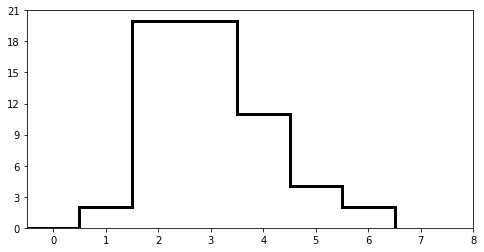

In [14]:
##I am going to build a distribution of mutations per clone, rather than mutations per position.
mutantCloneCounts = []
for iterate in range(len(cleanedAaAlignment)-1):
    #print(iterate)
    expression = (1 for a, b in zip(cleanedAaAlignment[0].seq, cleanedAaAlignment[iterate+1].seq) if a != b)
    mutantCloneCounts.append(np.sum(np.fromiter(expression, int)))
#countBins = list(range(max(mutantCloneCounts)+2))
countBins = np.arange(max(mutantCloneCounts)+2) - 0.5

fig4 = figure(figsize=(8,4))
ax4 = sns.distplot(mutantCloneCounts, countBins, kde=False, color="black", label="TM4-6 mutations per clone", 
                   hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "k"})
xlim((-0.5,max(mutantCloneCounts)+2))
ax4.yaxis.set_major_locator(MaxNLocator(integer=True))

#savefig(root_dir+'/mutantCountCloneHist_TMH4-6_all_uniques_191124.pdf', dpi=300, transparent=True)

In [15]:
#Printing file list
fileList = [f for f in listdir(root_dir) if f.endswith(".csv")]
print("Sequence files:")
print("\n".join(fileList))

Sequence files:
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier-no493_191128_Autocrine_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier-no493_191128_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier_191031_Autocrine_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier_191031_mutantCounts.csv
E05973_TMH10-12_v1-v2-sort04-05-05a_v3-sort04a-05_v4-sort04_all_unique cleaned-no-outlier_191124_Autocrine_mutantCounts.csv
E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_mutantCounts.csv
E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_unique_no-outliers 191031_Autocrine_mutantCounts.csv
E05973_TMH4-6_v1-sort04_v3-sort04_v4-sort04_all_unique_no-outliers 191031_mutantCounts.csv
Fungiv2p1_hmmalign-hhfilter-focus-

In [17]:
##I am going to import all the medianTable data from the plateAutocrine assays of TM4-6/v1-v3-v4 and TM10-12/v1-v2-v3-v4 into a pandas dataframe.
rawSeqMedianTable = pd.read_csv(root_dir+"/SeqPlateAutocrineExpts_TM4-6_no-outliers_191031.csv")
rawSeqMedianTable = rawSeqMedianTable.drop(columns="Unnamed: 6")
rawSeqMedianTable.head()

,SeqID,ExptLabel,Sample,Well,GFP,RFP,NormGFP
0,3xs-E021-491_01-B3_to_YALI0E05973-pSS021_conse...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x-sm,B3,0.465869,1.156520,0.314376
1,3x-E021-491_01-A7_to_YALI0E05973-pSS021_consen...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x,A7,0.424672,0.750906,0.273179
2,3xs-E021-491_01-B6_to_YALI0E05973-pSS021_conse...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x-sm,B6,0.428417,0.941503,0.276924
3,3xs-E021-491_01-B7_to_YALI0E05973-pSS021_conse...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x-sm,B7,0.537248,0.948643,0.385755
4,3xs-E021-491_02-C2_to_YALI0E05973-pSS021_conse...,Expt02/clone02,TMH4-6/v1/0.5mM/sort04-3x-sm,C2,0.737011,0.608411,0.490324


In [18]:
##Defining functions to add columns to the dataframe
def insertSeq (row):
    seqHash = {}
    for record in cleanedAaAlignment:
        key = {record.id: str(record.seq)}
        seqHash.update(key)
    
    return str(seqHash[row['SeqID']])

def insertMutCount (row):
    seqHash = {}
    for record in cleanedAaAlignment:
        key = {record.id: str(record.seq)}
        seqHash.update(key)
    
    expression = (1 for a, b in zip(cleanedAaAlignment[0].seq, seqHash[row['SeqID']]) if a != b)
    return np.sum(np.fromiter(expression, int))

In [19]:
seqHash = {}
for record in cleanedAaAlignment:
    #print(record.id)
    key = {record.id: str(record.seq)}
    seqHash.update(key)
    
#expression = (1 for a, b in zip(cleanedAaAlignment[0].seq, seqHash[rawSeqMedianTable.iloc[2]['SeqID']]) if a != b)
print(np.sum(np.fromiter(expression, int)))
print(len(cleanedAaAlignment[1:]))
print(len(rawSeqMedianTable))
#seqHash

##Somehow there is a weird extra listing in the FASTA IDs coming from Geneious for only some of the sequences, which is very odd...

0
59
59


In [20]:
##Adding sequences and mutantcounts as separate columns.
processSeqMedianTable = rawSeqMedianTable.copy()
processSeqMedianTable['Seq'] = processSeqMedianTable.apply(lambda row: insertSeq(row), axis = 1)
processSeqMedianTable['mutCount'] = processSeqMedianTable.apply(lambda row: insertMutCount(row), axis = 1)

outputFile = alignFile.split(".")[1]+"_Autocrine_mutantCounts.csv"
#print(outputFile)
processSeqMedianTable.to_csv('.'+outputFile, sep='\t', encoding='utf-8', index=False, header=False)

processSeqMedianTable.head()

,SeqID,ExptLabel,Sample,Well,GFP,RFP,NormGFP,Seq,mutCount
0,3xs-E021-491_01-B3_to_YALI0E05973-pSS021_conse...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x-sm,B3,0.465869,1.156520,0.314376,YHSWSLTLVIMAGLPIIVLVAMGVAPRLQRHFRDYKGVITDASVVI...,2
1,3x-E021-491_01-A7_to_YALI0E05973-pSS021_consen...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x,A7,0.424672,0.750906,0.273179,YHSRSLTLVIMAGLPIIVLVAMGVAPRLQRHFRGYKGVITDASVMI...,3
2,3xs-E021-491_01-B6_to_YALI0E05973-pSS021_conse...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x-sm,B6,0.428417,0.941503,0.276924,YHSWSLTLVIMAGLPIIVLVAMGVAPRLQRHFRDYKGVITDASVMI...,1
3,3xs-E021-491_01-B7_to_YALI0E05973-pSS021_conse...,Expt01/clone01,TMH4-6/v1/0.5mM/sort04-3x-sm,B7,0.537248,0.948643,0.385755,YHSWSLTLVIMAGLPIIVLVAMGVAPRLQRHFRGYKGVITDASVMI...,3
4,3xs-E021-491_02-C2_to_YALI0E05973-pSS021_conse...,Expt02/clone02,TMH4-6/v1/0.5mM/sort04-3x-sm,C2,0.737011,0.608411,0.490324,YHSWSLTLVIMAGLPIIVLVAMGVAPRLQRHLRDYKGVITDASDMI...,4


The Pearson correlation coefficient is:  0.2118708217366073
The Spearman correlation coefficient is:  0.2733485016420458 , with a p-value of:  0.03619033529749498


(0, 0.8888959729999999)

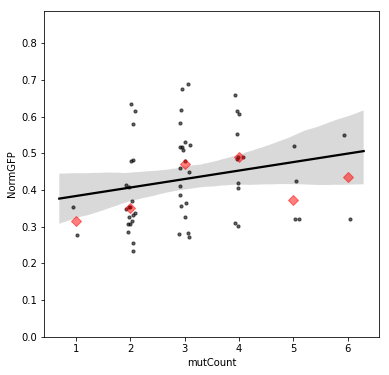

In [21]:
pearsonCoeff = np.corrcoef([processSeqMedianTable['mutCount'].get_values(), 
                            processSeqMedianTable['NormGFP'].get_values()])
print("The Pearson correlation coefficient is: ", pearsonCoeff[0, 1])

spearmanCoeff, pVal = spearmanr(processSeqMedianTable['mutCount'].get_values(), 
                            processSeqMedianTable['NormGFP'].get_values())
print("The Spearman correlation coefficient is: ", spearmanCoeff, ", with a p-value of: ", pVal)

##Plotting the autocrine signal of clones against the mutants in each clone relative to WT YlSte6.
fig5 = figure(figsize=(6,6))

sns.regplot(x="mutCount", y="NormGFP", scatter=True, data=processSeqMedianTable, ci=95, scatter_kws={"s":10, "alpha":0.6}, x_jitter=.1, color="black")
sns.regplot(x="mutCount", y="NormGFP", scatter=True, data=processSeqMedianTable, ci=None, x_estimator=np.median, color="red", marker="D", fit_reg=False, scatter_kws={"alpha":0.5})
#sns.swarmplot(x="mutCount", y="NormGFP", data=processSeqMedianTable, dodge=True, color="grey", size=5)
ylim((0,processSeqMedianTable['NormGFP'].max()+0.2))
#savefig(root_dir+'/mutantCountAutocrineSignal_TMH4-6_seqClones_191124.pdf', dpi=300, transparent=True)

The Pearson correlation coefficient is:  0.36439470019593556
The Spearman correlation coefficient is:  0.3750152775201807 , with a p-value of:  0.005660656526438356


(0, 0.8888959729999999)

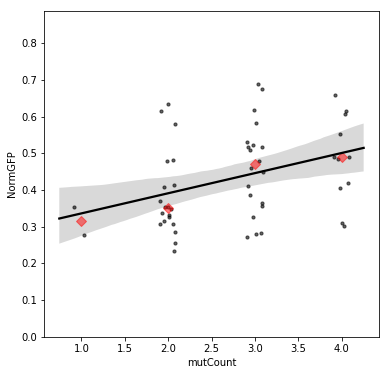

In [22]:
test = processSeqMedianTable.copy()
test = test[test['mutCount'] < 5]
pearsonCoeff = np.corrcoef([test['mutCount'].get_values(), 
                            test['NormGFP'].get_values()])
print("The Pearson correlation coefficient is: ", pearsonCoeff[0, 1])

spearmanCoeff, pVal = spearmanr(test['mutCount'].get_values(), 
                            test['NormGFP'].get_values())
print("The Spearman correlation coefficient is: ", spearmanCoeff, ", with a p-value of: ", pVal)

##Plotting the autocrine signal of clones against the mutants in each clone relative to WT YlSte6.
fig5 = figure(figsize=(6,6))

sns.regplot(x="mutCount", y="NormGFP", scatter=True, data=test, ci=95, scatter_kws={"s":10, "alpha":0.6}, x_jitter=.1, color="black")
sns.regplot(x="mutCount", y="NormGFP", scatter=True, data=test, ci=None, x_estimator=np.median, color="red", marker="D", fit_reg=False, scatter_kws={"alpha":0.5})
#sns.swarmplot(x="mutCount", y="NormGFP", data=processSeqMedianTable, dodge=True, color="grey", size=5)
ylim((0,processSeqMedianTable['NormGFP'].max()+0.2))
#savefig(root_dir+'/mutantCountAutocrineSignal_TMH4-6_seqClones_191124.pdf', dpi=300, transparent=True)

In [23]:
print(len(cleanedAaAlignment[1:]))

59


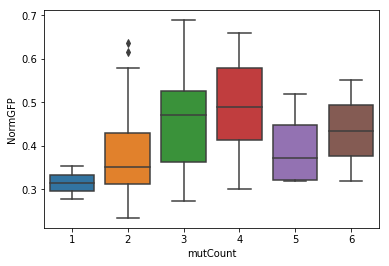

In [24]:
sns.boxplot(x="mutCount", y="NormGFP", data=processSeqMedianTable)

[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 0, 2, 3, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1]
[ 5 37 15  2]


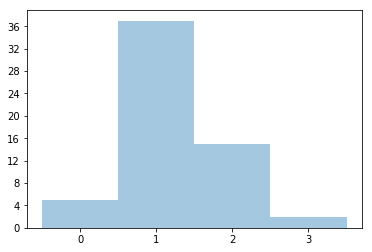

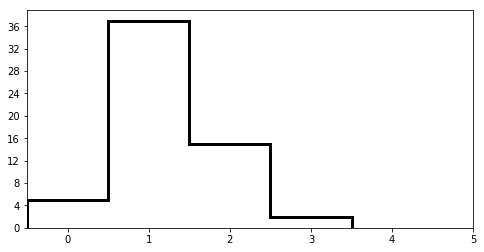

In [25]:
##I am going to write code that elucidates the number of enriched and tested mutations contained in each clone. 
#mutantCounts = [[0 for col in range(len(cleanedTestAlignment[0].seq))] for row in range(len(cleanedTestAlignment)-1)]
enrichMutantCounts = [0 for row in range(len(cleanedAaAlignment[1:]))]

startTMH4to6 = 199
startTMH10to12 = 851
enrichedResi = np.array([230, 234, 246, 247, 259, 263, 269, 322, 331, 339])

#for resi in (enrichedResi-startTMH10to12):
#    print(cleanedAaAlignment[0].seq[resi])

seqCount = 0
for record in cleanedAaAlignment[1:]:
    for resi in (enrichedResi-startTMH4to6):
        #print(residue, residueCount, seqCount)
        if record.seq[resi] != cleanedAaAlignment[0].seq[resi]:
            enrichMutantCounts[seqCount] += 1
    seqCount +=1

print(enrichMutantCounts)
bins = np.arange(max(enrichMutantCounts)+2)

histEnrichMutantCounts, bin_edges = np.histogram(enrichMutantCounts, bins)
print(histEnrichMutantCounts)

ax2 = sns.distplot(enrichMutantCounts, bins-0.5, kde=False, label="No. of enriched mutations/clone")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
#savefig(root_dir+'/positivelyIDPositions_TMH4-6_seqClones_191124.pdf', dpi=300, transparent=True)

fig4 = figure(figsize=(8,4))
ax4 = sns.distplot(enrichMutantCounts, bins-0.5, kde=False, color="black", label="enriched clones in TM10-12 clones", 
                   hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "k"})
xlim((-0.5,max(enrichMutantCounts)+2))
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.yaxis.set_major_locator(MaxNLocator(integer=True))
#savefig(root_dir+'/positivelyIDPositions_TMH4-6_seqClones_histOutline_191201.pdf', dpi=300, transparent=True)

In [26]:
##Input fasta file of ScSte6 TM 4-6 and TM 10-12 sequences for the analysis, these are not alignments.

ScSte6SeqFile = data_file+"/SaceSte6_TMDs_191121.fasta"
ScSte6ROI = list(SeqIO.parse(ScSte6SeqFile, "fasta"))
print(ScSte6ROI[0].id)

SaceSte6|TM4-6


In [27]:
##This is to parse mutations in selected clones comparing their identity to that present in YlSte6 and ScSte6. There are going to be 3 bins:
## 1) Mutation away from YlSte6 to ScSte6 residue
## 2) Mutations away from the residue conserved in both Sc and Yl.
## 3) Mutations that is distinct from Sc and Yl, with them being different.

binnedMutantCounts = []

startTMH4to6 = 199
startTMH10to12 = 851

#for resi in (enrichedResi-startTMH10to12):
#    print(cleanedAaAlignment[0].seq[resi])

seqCount = 0
for record in cleanedAaAlignment[1:]:
    residueCount = 0
    bin1 = 0
    bin2 = 0
    bin3 = 0
    for residue in record.seq:
        #print(residue, residueCount, seqCount)
        if residue != cleanedAaAlignment[0].seq[residueCount]:
            if residue == ScSte6ROI[0].seq[residueCount]:
                bin1 += 1
            elif (cleanedAaAlignment[0].seq[residueCount] == ScSte6ROI[0].seq[residueCount]) and (residue != ScSte6ROI[0].seq[residueCount]):
                bin2 += 1
            elif residue != ScSte6ROI[0].seq[residueCount]:
                bin3 += 1
        residueCount += 1
    binnedMutantCounts.append([str(record.id), int(bin1), int(bin2), int(bin3), int(bin1+bin2+bin3)])
    seqCount +=1

print("Analyzed %i clones:" % int(seqCount))
print(np.array(binnedMutantCounts).shape)
#print(np.array(binnedMutantCounts)[:,4])

plotBinnedMutantCounts = pd.DataFrame(np.array(binnedMutantCounts))
#plotBinnedMutantCounts.iloc[:,1:].astype("int")
plotBinnedMutantCounts.head()

Analyzed 59 clones:
(59, 5)


,0,1,2,3,4
0,3xs-E021-491_01-B3_to_YALI0E05973-pSS021_conse...,0,1,1,2
1,3x-E021-491_01-A7_to_YALI0E05973-pSS021_consen...,0,1,2,3
2,3xs-E021-491_01-B6_to_YALI0E05973-pSS021_conse...,0,1,0,1
3,3xs-E021-491_01-B7_to_YALI0E05973-pSS021_conse...,0,1,2,3
4,3xs-E021-491_02-C2_to_YALI0E05973-pSS021_conse...,0,1,3,4


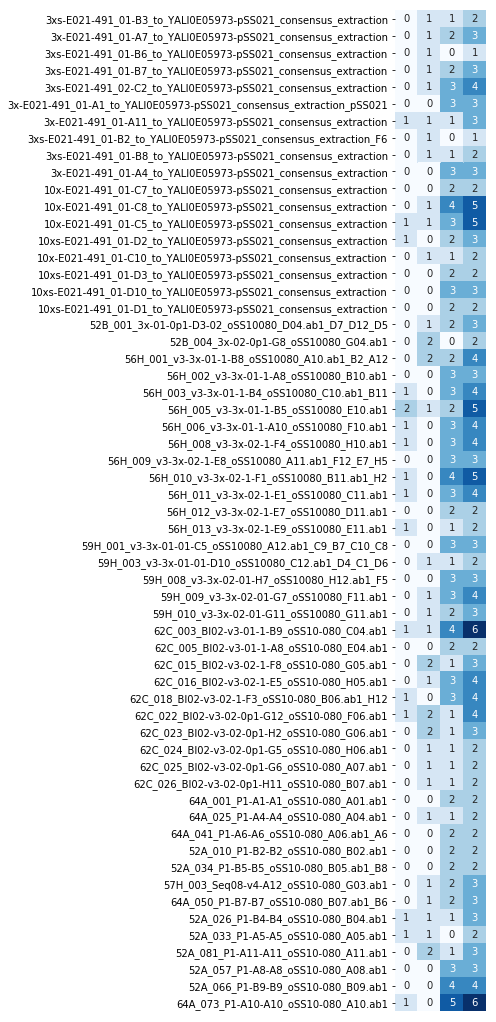

In [28]:
fig1 = figure(figsize=(7,14.3))
ax = sns.heatmap(plotBinnedMutantCounts.iloc[:,1:].astype("int"), linewidths=0, cmap="Blues", 
                 yticklabels=plotBinnedMutantCounts.iloc[:,0].values, xticklabels=False, annot=True, cbar=False)
plt.yticks(rotation=0)
plt.tight_layout()
#savefig(root_dir+'/compareSc-YlSte6_TMH4-6_seqClones_191125.pdf', dpi=300, transparent=True)

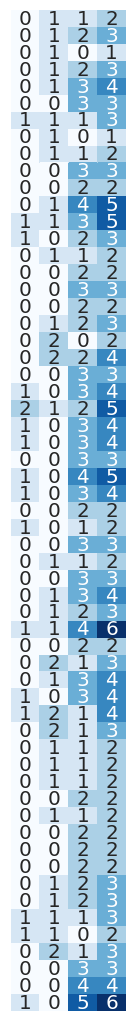

In [34]:
fig1 = figure(figsize=(2,14.3))
ax = sns.heatmap(plotBinnedMutantCounts.iloc[:,1:].astype("int"), linewidths=0, cmap="Blues", yticklabels=False, xticklabels=False, annot=True, annot_kws={"size": 20}, cbar=False)
plt.yticks(rotation=0)
plt.tight_layout()
#savefig(root_dir+'/compareSc-YlSte6_TMH4-6_seqClones_noLabel_200111.pdf', dpi=300, transparent=True)